# Introduction
This code is an MCMC fit for sine curves using the emcee package (https://emcee.readthedocs.io/en/stable/). The likelihood function, priors, and random additions are set up for you already. 

### You will be changing:

1.) The initial values of the algorithm - think about how you can find these analytically based on the data that you have

2.) The number of steps the algorithm takes - think about how the number of steps you take affects the quality of your fit

3.) The generated error - think about how error changes how percice your fit can be

### A few thing to note on the items that are being plotted or printed:

1.) Trace: this shows how much your values are moving around during your fit, so how much variation you're getting. The more jagged the plot is, the more variation you get. Note the very jagged part right at the beginning, that's your burn-in. The burn-in is your MCMC figuring out what value it wants to settle on before getting into a holding pattern on that value. It is usually discarded in the next plots.

2.) Corner Plots: these show how constrained the fit is. Good corner plots should look something like this: (https://www.researchgate.net/figure/Corner-plot-resulting-from-our-MCMC-analysis-of-the-TESS-photometry-of-14-Peg-Red_fig1_347534572), where there's a good spread of values that cluster around a central point, which is our correct value. 

3.) The MCMC's Answer: these values are the answers from MCMC with errors. Our errors are calculated by getting the difference between our 50th percentile answer and our 16th percentile answer, and our 84th percentile answer and our 50th percentile answer for our lower error bar and upper error bar, respectively.

4.) Our Final Fitted Plot: note that I declare the model within the plt.plot() call itself. You might want to change this later depending on how you use this algorithm.

### Final Notes:
Values you can and should change are marked with a comment with two exclamation points. Running a 5000 step run takes about three seconds for me, it should take around that amount of time for you. Once you've gotten used to playing around with a generated fit and you've gotten used to sine fitting TOI-4468 without using MCMC, switch over to using the RV data for TOI-4468. It'll provide some interesting challenges, especially given that you will have to phase fold before you input it into the MCMC run.

A few important notes about MCMC. Depending on how your traces look, you might need to throw away more steps in your burn-in. Look for where that the line flattens out, that's how many steps you'll want to throw away. The farther away from the real values your fit is, the larger your burn-in. In MCMC, your fit will be improved the more steps you add, to a point. At a certain point, if you add more steps, you're just wasting time. Since these values have errors on them, we can only be so accurate in our knowledge of the "true value." This is just an approximation, a very good one, but still just an approximation. Keep that in mind before you ask it to run a billion steps. Finally, when you use this code for TOI-4468, I would suggest making a copy of this notebook and editing that so you still have whatever edits you've made here along with the new work you're going to do. I will always have this original copy of the notebook, so if you need it, it's always here.

Hope this is helpful, good luck, and happy fitting!

In [1]:
# Import statements - I use a lot, don't worry about these
import numpy as np

import matplotlib.pyplot as plt

from scipy.optimize import minimize

import emcee

import corner

from IPython.display import display, Math

import matplotlib as mpl
# mpl.rc('font', family='serif', serif='Times New Roman')
# mpl.rcParams['figure.dpi'] = 600
import seaborn as sns
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:96% !important; }</style>"))
%matplotlib inline
import glob 
import pandas as pd
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

# plt.rcParams.update({'figure.figsize': (12,6)})
#from astroquery.simbad import Simbad
#from astroquery.vizier import Vizier
#from astroquery.mast import Observations
#import astropy.units as u

#Keplerspline:
from keplersplinev2 import *
import lightkurve as lk
from astropy.io import fits
import sys

#Batman
import batman

import warnings
warnings.filterwarnings('ignore')

import scipy.stats as stats

from copy import deepcopy
import statistics as st
from astropy.table import Table

/var/folders/dk/lq6j7scd35j5b_4chx7963xr0000gp/T/ipykernel_24040/215657510.py:18: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# Raw initialization time:

In [3]:
Sector41 = '/Users/zijunhe/Documents/MAST_TTV_Data/TESS/S41/tess2021204101404-s0041-0000000441763252-0212-s_lc.fits'
Sector48 = '/Users/zijunhe/Documents/MAST_TTV_Data/TESS/S48/tess2022027120115-s0048-0000000441763252-0219-s_lc.fits'
Sector49 = '/Users/zijunhe/Documents/MAST_TTV_Data/TESS/S49/tess2022057073128-s0049-0000000441763252-0221-s_lc.fits'
Sector50 = '/Users/zijunhe/Documents/MAST_TTV_Data/TESS/S50/tess2022085151738-s0050-0000000441763252-0222-s_lc.fits'
Sector51 = '/Users/zijunhe/Documents/MAST_TTV_Data/TESS/S51/tess2022112184951-s0051-0000000441763252-0223-s_lc.fits'
Sector52 = '/Users/zijunhe/Documents/MAST_TTV_Data/TESS/S52/tess2022138205153-s0052-0000000441763252-0224-s_lc.fits'
Sector53 = '/Users/zijunhe/Documents/MAST_TTV_Data/TESS/S53/tess2022164095748-s0053-0000000441763252-0226-s_lc.fits'
Sector54 = '/Users/zijunhe/Documents/MAST_TTV_Data/TESS/S54/tess2022190063128-s0054-0000000441763252-0227-s_lc.fits'

Sector55 = '/Users/zijunhe/Documents/MAST_TTV_Data/TESS/S55/tess2022217014003-s0055-0000000441763252-0242-s_lc.fits'
Sector56 = '/Users/zijunhe/Documents/MAST_TTV_Data/TESS/S56/tess2022244194134-s0056-0000000441763252-0243-s_lc.fits'
Sector57 = '/Users/zijunhe/Documents/MAST_TTV_Data/TESS/S57/tess2022273165103-s0057-0000000441763252-0245-s_lc.fits'
Sector58 = '/Users/zijunhe/Documents/MAST_TTV_Data/TESS/S58/tess2022302161335-s0058-0000000441763252-0247-s_lc.fits'
Sector59 = '/Users/zijunhe/Documents/MAST_TTV_Data/TESS/S59/tess2022330142927-s0059-0000000441763252-0248-s_lc.fits'
Sector60 = '/Users/zijunhe/Documents/MAST_TTV_Data/TESS/S60/tess2022357055054-s0060-0000000441763252-0249-s_lc.fits'
Sector73 = '/Users/zijunhe/Documents/MAST_TTV_Data/TESS/S73/tess2023341045131-s0073-0000000441763252-0268-s_lc.fits'
Sector75 = '/Users/zijunhe/Documents/MAST_TTV_Data/TESS/S75/tess2024030031500-s0075-0000000441763252-0270-s_lc.fits'
Sector76 = '/Users/zijunhe/Documents/MAST_TTV_Data/TESS/S76/tess2024058030222-s0076-0000000441763252-0271-s_lc.fits'
Sector77 = '/Users/zijunhe/Documents/MAST_TTV_Data/TESS/S77/tess2024085201119-s0077-0000000441763252-0272-s_lc.fits'
Sector78 = '/Users/zijunhe/Documents/MAST_TTV_Data/TESS/S78/tess2024114025118-s0078-0000000441763252-0273-s_lc.fits'
Sector80 = '/Users/zijunhe/Documents/MAST_TTV_Data/TESS/S80/tess2024170053053-s0080-0000000441763252-0275-s_lc.fits'
Sector81 = '/Users/zijunhe/Documents/MAST_TTV_Data/TESS/S81/tess2024196212429-s0081-0000000441763252-0276-s_lc.fits'
Sector82 = '/Users/zijunhe/Documents/MAST_TTV_Data/TESS/S82/tess2024223182411-s0082-0000000441763252-0278-s_lc.fits'
Sector83 = '/Users/zijunhe/Documents/MAST_TTV_Data/TESS/S83/tess2024249191853-s0083-0000000441763252-0280-s_lc.fits'


In [4]:
df_name = Table.read(Sector41,  format='fits')
print(df_name)

        TIME           TIMECORR    CADENCENO  ...   POS_CORR1      POS_CORR2   
BJD - 2457000, days       d                   ...     pixels         pixels    
------------------- -------------- ---------- ... -------------- --------------
      2.4199834e+03 -6.9394009e-04     858621 ...             --             --
      2.4199848e+03 -6.9394172e-04     858622 ...             --             --
      2.4199862e+03 -6.9394335e-04     858623 ...             --             --
      2.4199876e+03 -6.9394498e-04     858624 ...             --             --
      2.4199890e+03 -6.9394661e-04     858625 ... -1.9793143e-03  1.1185962e-02
      2.4199904e+03 -6.9394824e-04     858626 ...  1.7643328e-03  1.3816524e-02
      2.4199918e+03 -6.9394981e-04     858627 ... -2.1848506e-03  9.0648765e-03
      2.4199932e+03 -6.9395144e-04     858628 ... -4.9070939e-03  8.9597590e-03
      2.4199946e+03 -6.9395301e-04     858629 ...  1.0846774e-03  8.5055614e-03
                ...            ...      

In [5]:
def data_initialization(sector_path):
    clean_flux = []
    clean_time = []
    df_name = Table.read(sector_path,  format='fits')
    dataframe = df_name.to_pandas()
    time_name = dataframe.iloc[:,0]
    flux_name = dataframe.iloc[:,7]
    for i in range(len(flux_name)):
        if not np.isnan(flux_name[i]):
            clean_flux.append(flux_name[i])
            clean_time.append(time_name[i])
    
    clean_flux = np.array(clean_flux)
    clean_time = np.array(clean_time)
    KS = keplersplinev2(clean_time, clean_flux, bkspace = 2)
    flux_norm = clean_flux/KS
    error_norm = np.std(flux_norm)
    data = pd.DataFrame(data={'time': clean_time, 'flux': flux_norm, 'error': error_norm})
    
    
    return data

In [6]:
Data41 = data_initialization(Sector41)
Data48 = data_initialization(Sector48)
Data49 = data_initialization(Sector49)
Data50 = data_initialization(Sector50)
Data51 = data_initialization(Sector51)
Data52 = data_initialization(Sector52)
Data53 = data_initialization(Sector53)
Data54 = data_initialization(Sector54)
Data55 = data_initialization(Sector55)
Data56 = data_initialization(Sector56)
Data57 = data_initialization(Sector57)
Data58 = data_initialization(Sector58)
Data59 = data_initialization(Sector59)
Data60 = data_initialization(Sector60)
Data73 = data_initialization(Sector73)
Data75 = data_initialization(Sector75)
Data76 = data_initialization(Sector76)
Data77 = data_initialization(Sector77)
Data78 = data_initialization(Sector78)
Data80 = data_initialization(Sector80)
Data81 = data_initialization(Sector81)
Data82 = data_initialization(Sector82)
Data83 = data_initialization(Sector83)
concat_targets = [Data41, Data48, Data49, Data50, Data51, Data52, Data53, Data54,Data55,Data56,Data57,Data58,Data59,Data60,Data73,Data75,Data76,Data77,Data78,Data80,Data81,Data82,Data83]
TTVdataframe = pd.concat(concat_targets)
print((TTVdataframe))
time = TTVdataframe.iloc[:,0]
flux = TTVdataframe.iloc[:,1]
error = TTVdataframe.iloc[:,2]

              time      flux     error
0      2419.989000  0.989011  0.007640
1      2419.990389  1.005775  0.007640
2      2419.991778  1.001030  0.007640
3      2419.993167  1.010224  0.007640
4      2419.994556  1.011005  0.007640
...            ...       ...       ...
17325  3584.369077  0.995619  0.007204
17326  3584.370466  0.993169  0.007204
17327  3584.371855  1.003664  0.007204
17328  3584.373244  0.997918  0.007204
17329  3584.374632  0.999676  0.007204

[344976 rows x 3 columns]


In [7]:
#Creation of original values
period = 2.770860
best_t0 = 2421.8415309739044
t0=2421.8415309739044#2438.4663346073316

In [8]:
epochs = np.arange(min(TTVdataframe.iloc[:,0]) + ((best_t0-min(TTVdataframe.iloc[:,0]))%period), max(TTVdataframe.iloc[:,0]), period)
#(t0-min(t))%p_orb)), max(t), p_orb)
print(epochs)

[2421.84153097 2424.61239097 2427.38325097 2430.15411097 2432.92497097
 2435.69583097 2438.46669097 2441.23755097 2444.00841097 2446.77927097
 2449.55013097 2452.32099097 2455.09185097 2457.86271097 2460.63357097
 2463.40443097 2466.17529097 2468.94615097 2471.71701097 2474.48787097
 2477.25873097 2480.02959097 2482.80045097 2485.57131097 2488.34217097
 2491.11303097 2493.88389097 2496.65475097 2499.42561097 2502.19647097
 2504.96733097 2507.73819097 2510.50905097 2513.27991097 2516.05077097
 2518.82163097 2521.59249097 2524.36335097 2527.13421097 2529.90507097
 2532.67593097 2535.44679097 2538.21765097 2540.98851097 2543.75937097
 2546.53023097 2549.30109097 2552.07195097 2554.84281097 2557.61367097
 2560.38453097 2563.15539097 2565.92625097 2568.69711097 2571.46797097
 2574.23883097 2577.00969097 2579.78055097 2582.55141097 2585.32227097
 2588.09313097 2590.86399097 2593.63485097 2596.40571097 2599.17657097
 2601.94743097 2604.71829097 2607.48915097 2610.26001097 2613.03087097
 2615.

<ErrorbarContainer object of 3 artists>

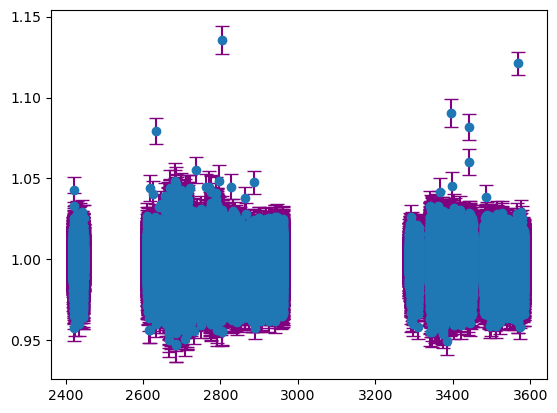

In [9]:
plt.errorbar(TTVdataframe.iloc[:,0], TTVdataframe.iloc[:,1], yerr=TTVdataframe.iloc[:,2], ecolor='purple', fmt='o', capsize=5, label="Data with asymmetric errors")

In [10]:
params = batman.TransitParams()       #object to store transit parameters
params.per = 2.770860                 #orbital period(days)
params.rp = 12.247/109/.79          #planet radius (in units of stellar radii)
params.a = 9.84875656                 #semi-major axis (in units of stellar radii)
params.inc = 90.0                      #orbital inclination (in degrees)
params.ecc = 0.0                       #eccentricity
params.w = 0.0                         #longitude of periastron (in degrees)
params.limb_dark = "quadratic"        #limb darkening model
params.u = [0.1,0.3]      #limb darkening coefficients [u1, u2, u3, u4]

In [11]:
#NOTE: ratio of planet radius to stellar radius
#Defining the Transit Model:
params.t0 = epochs[0]                       #time of inferior conjunction
time_example = TTVdataframe.loc[(TTVdataframe['time'] > epochs[0]  - 0.4) & (TTVdataframe['time'] < epochs[0]  + 0.4) & (pd.notnull(TTVdataframe['flux'])), ['time']]
flux_example = TTVdataframe.loc[(TTVdataframe['time'] > epochs[0]  - 0.4) & (TTVdataframe['time'] < epochs[0]  + 0.4) & (pd.notnull(TTVdataframe['flux'])), ['flux']]
error_example = TTVdataframe.loc[(TTVdataframe['time'] > epochs[0]  - 0.4) & (TTVdataframe['time'] < epochs[0]  + 0.4) & (pd.notnull(TTVdataframe['flux'])), ['error']]
m = batman.TransitModel(params, np.asarray(time_example.values.flatten()))    #initializes model

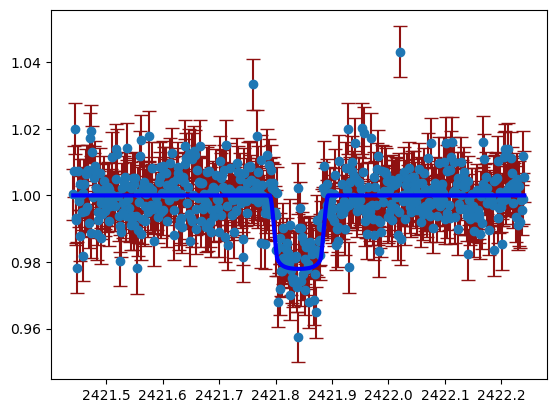

In [12]:
#    params.inc = i                           #updates planet radius
new_flux = m.light_curve(params)        #recalculates light curve
plt.plot(time_example.values.flatten(), flux_example.values.flatten(), '.', color = 'black')
plt.errorbar(time_example.values.flatten(), flux_example.values.flatten(), yerr=error_example.values.flatten(), ecolor='#8f1111', fmt='o', capsize=5, label="Data with asymmetric errors")
plt.plot(time_example.values.flatten(), new_flux,'blue',linewidth=3, zorder=10)

In [13]:
# Define Priors - The boundaries on what is allowed for our model
## Returning 0 shows that the values are valid for the model
## Returning -infinity shows that the values are not valid for the model
def log_prior(theta):
    ## Get our parameters for the model
    t0 = theta
    
    ## Check if the t0 value is less than or greater than 0.1
    if e+0.2>t0>e-0.2: # !! Change these if you want a more constrained fit
        return 0
    
    return -np.inf

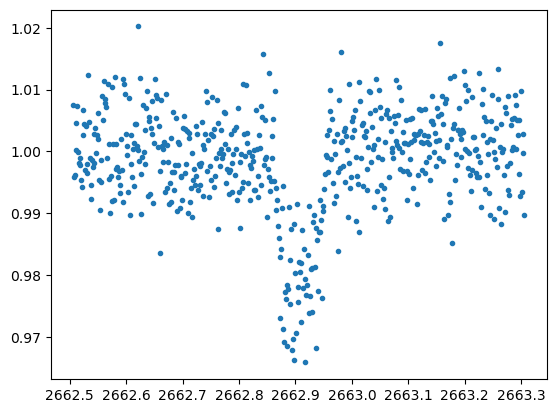

In [14]:
epochs_sim = 2662.90635097
time_temp = time[(time > epochs_sim - 0.4) & (time < epochs_sim + 0.4)]
flux_temp = flux[(time > epochs_sim - 0.4) & (time < epochs_sim + 0.4)]
plt.plot(time_temp,flux_temp,'.')

In [15]:
# Define Likelihood Function
def log_likelihood_TTV(t0, time, flux, flux_err):
    ## Get our parameters for the model
    params.t0 = t0
    
    ## Check our parameters against our priors
    ## If lp is negative infinity, the values are invalid, a model will not be calculated, 
    ##  and these values will be labeled as very unlikely
    lp = log_prior(t0)
    if not np.isfinite(lp):
        return -np.inf
    
    ## Generate a new version of our model using our current x values
    model = batman.TransitModel(params, time)
    model_flux = model.light_curve(params)
    
    
    ## Compare using chi squared
    residuals = flux - model_flux
    ## Return our chi squared value for later evaluation done by emcee
    return -0.5 * np.sum((residuals**2) / (flux_err**2))

In [16]:
# Example data (replace `t`, `flux`, and `error` with your actual data arrays)
# t, flux, error = ... (define these as lists of arrays per epoch)
# epochs = ... (define epochs array)

ndim = 1
nwalkers = 24

# Store t0 values for each epoch fit
t0values = []
t0values_upper = []
t0values_lower = []

for e in epochs:  # Adjust range based on the number of epochs
    # Initialize walkers around the current epoch's t0 value
    time_temp = []
    flux_temp = []
    error_temp = []
        
    time_temp = TTVdataframe.loc[(TTVdataframe['time'] > e - 0.4) & (TTVdataframe['time'] < e + 0.4) & (pd.notnull(TTVdataframe['flux'])), ['time']]
    flux_temp = TTVdataframe.loc[(TTVdataframe['time'] > e - 0.4) & (TTVdataframe['time'] < e  + 0.4) & (pd.notnull(TTVdataframe['flux'])), ['flux']]
    error_temp = TTVdataframe.loc[(TTVdataframe['time'] > e  - 0.4) & (TTVdataframe['time'] < e + 0.4) & (pd.notnull(TTVdataframe['flux'])), ['error']]

    if np.isscalar(time_temp) == True:
        t0values.append(np.nan)
        t0values_upper.append(np.nan)
        t0values_lower.append(np.nan)
        continue
    elif len(time_temp) < 450:
        t0values.append(np.nan)
        t0values_upper.append(np.nan)
        t0values_lower.append(np.nan)
        continue
    else:
        
        random_additions = np.random.rand(nwalkers, ndim) * 0.0000001
        p0 = np.add(e, random_additions)
    
        # Declare the sampler for the current epoch
        sampler = emcee.EnsembleSampler(
            nwalkers, ndim, log_likelihood_TTV,
            args=(np.asarray(time_temp.values.flatten()), np.asarray(flux_temp.values.flatten()), np.asarray(error_temp.values.flatten()))
        )
        sampler.run_mcmc(p0, 5000, progress=True)
    
        ## Retrieve samples and plot the trace for current epoch
        samples = sampler.get_chain()
        #fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
        #labels = ['t0']
    
        #ax = axes
        #ax.plot(samples[:, :, 0], "k", alpha=0.3)
        #ax.set_xlim(0, len(samples))
        #ax.set_ylabel(labels[0])
        #ax.yaxis.set_label_coords(-0.1, 0.5)
        #ax.set_xlabel("Step Number")
        #plt.show()

        # Discard burn-in samples, flatten chain, and plot corner plot for posterior distribution
        flat_samples = sampler.get_chain(discard=1000, thin=11, flat=True)
        #fig = corner.corner(flat_samples, labels=labels)
        #plt.show()

        # Calculate and display median and uncertainties for t0
        mcmc = np.percentile(flat_samples[:, 0], [16, 50, 84])
        q = np.diff(mcmc)
        #txt = r"\mathrm{{{3}}} = {0:.7f}_{{-{1:.7f}}}^{{+{2:.7f}}}"
        #txt = txt.format(mcmc[1], q[0], q[1], labels[0])
        #display(Math(txt))
    
        # Save the best-fit t0 value for this epoch
        t0values.append(mcmc[1])
        t0values_upper.append(q[1])
        t0values_lower.append(q[0])
        # Update model with best-fit t0 to plot the fitted light curve
        params.t0 = mcmc[1]
        best_fit = batman.TransitModel(params, time_temp.values.flatten())  # Use BATMAN with current t0
        best_flux = best_fit.light_curve(params)

        # Plot data and best-fit model for the current epoch
        #plt.figure(figsize=(12, 6))
        #plt.plot(time_temp.values.flatten(), flux_temp.values.flatten(), "k.", label="Data")
        #plt.plot(time_temp.values.flatten(), best_flux, "r-", label="Best-fit Model")
        #plt.xlabel("Time")
        #plt.ylabel("Flux")
        #plt.legend()
        #plt.show()

# At the end, `t0values` contains the best-fit t0 for each epoch.


100%|██████████| 5000/5000 [00:18<00:00, 264.53it/s]


In [17]:
timeepoch = []
for i in range(len(epochs)):
    timeepoch.append(i+1)

In [18]:
#ORIGINAL METHOD USED FOR TTV CALCULATION - OBSOLETE!
#CTTresidualsminutes = []
#CTTresiduals = []
#CTTresiduals = [t0values - epoch for t0values, epoch in zip(t0values, epochs)]
#CTTresidualsminutes = [value * (24*60) for value in CTTresiduals]

#RESIDUALS IN MINUTESSSSS!!!!!!
lowererrminutes = [value * (24*60) for value in t0values_lower]
uppererrminutes = [value * (24*60) for value in t0values_upper]
#RESIDUALS IN SECONDS!!!!!
lowererrseconds = [value * (24*60*60) for value in t0values_lower]
uppererrseconds = [value * (24*60*60) for value in t0values_upper]
#print(CTTresidualsminutes)

Text(0, 0.5, 'Date (BJD)')

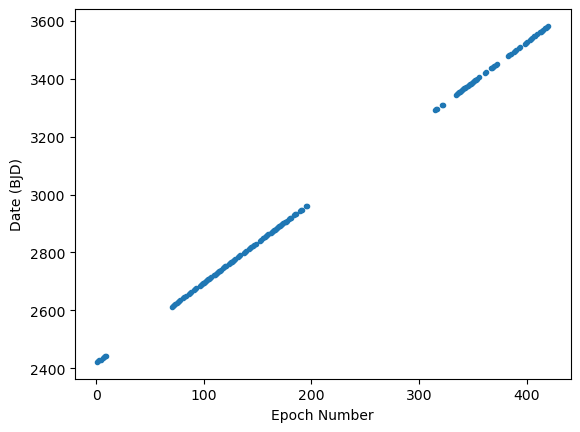

In [19]:
errorssecond = [lowererrseconds, uppererrseconds]
errorsminute = [lowererrminutes, uppererrminutes]
dayerror = [t0values_lower, t0values_upper]
plt.plot(timeepoch, t0values, '.')
plt.xlabel("Epoch Number")
plt.ylabel("Date (BJD)")
#plt.errorbar(timeepoch, t0values, yerr=error, fmt='o', ecolor='blue', capsize=5, label='Data with error bars')

In [20]:
#MCMC Fitting for the Residual Calculation

In [21]:
def ttv_function(t, s, t0):
    return s * t + t0


In [22]:
# Define Priors - The boundaries on what is allowed for our model
## Returning 0 shows that the values are valid for the model
## Returning -infinity shows that the values are not valid for the model
def log_prior(theta):
    ## Get our parameters for the model
    s, t0 = theta
    
    ## Check if the t0 value is less than or greater than 0.1
    if -30<s<30: # !! Change these if you want a more constrained fit
        return 0
    
    return -np.inf

In [23]:
# Define Likelihood Function
def log_likelihood(parameters, time, ttv, ttv_err):
    ## Get our parameters for the model
    s, t0 = parameters
    
    ## Check our parameters against our priors
    ## If lp is negative infinity, the values are invalid, a model will not be calculated, 
    ##  and these values will be labeled as very unlikely
    lp = log_prior(parameters)
    if not np.isfinite(lp):
        return -np.inf
    
    ## Generate a new version of our model using our current x values
    model = s*time+t0
    
    ## Compare using chi squared
    chisquared = np.nansum(((ttv-model)**2/(ttv_err**2)))
    ## Return our chi squared value for later evaluation done by emcee
    return (-0.5 * chisquared)

100%|██████████| 5000/5000 [00:08<00:00, 603.36it/s]


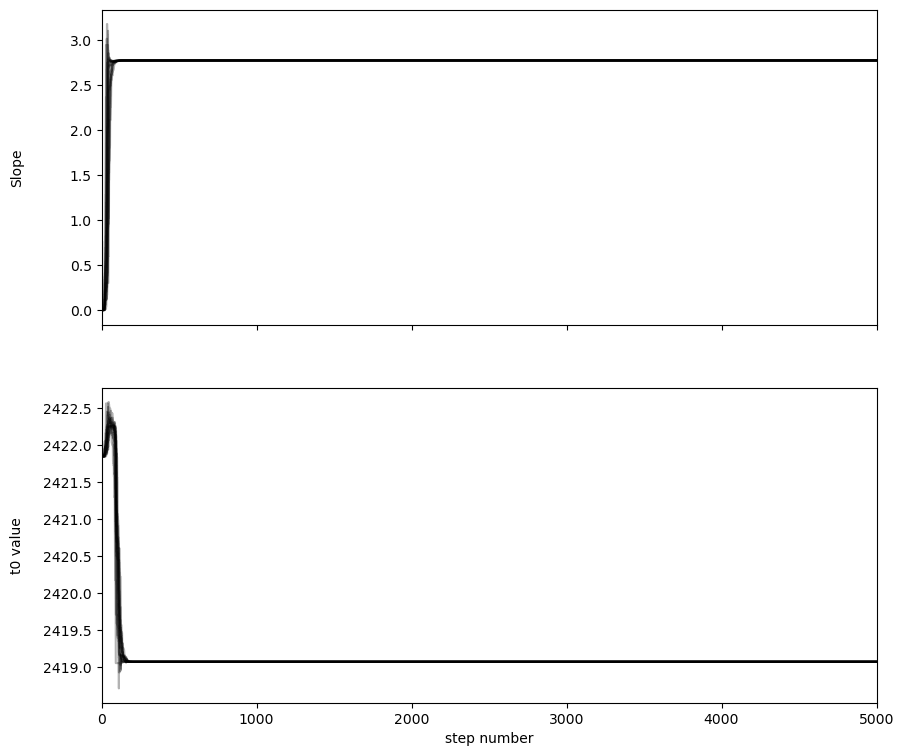

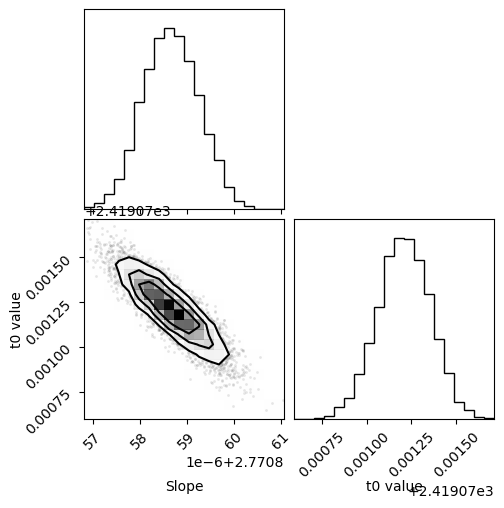

In [24]:
# Example data (replace `t`, `flux`, and `error` with your actual data arrays)
# t, flux, error = ... (define these as lists of arrays per epoch)
# epochs = ... (define epochs array)

ndim = 2
nwalkers = 16

random_additions = np.random.rand(nwalkers, ndim) * 0.003

p0 = np.add(np.asarray([0,epochs[0]]), random_additions)

# Declare the sampler for the current epoch
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_likelihood,
    args=(np.asarray(timeepoch), np.asarray(t0values), np.asarray(dayerror))
)
sampler.run_mcmc(p0, 5000, progress=True)

    
fig, axes = plt.subplots(ndim, figsize=(10, 9), sharex=True)
samples = sampler.get_chain()
labels = ['Slope', 't0 value']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

# Discard burn-in samples, flatten chain, and plot corner plot for posterior distribution
flat_samples = sampler.get_chain(discard=1000, thin=11, flat=True)
fig = corner.corner(flat_samples, labels=labels)
plt.show()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

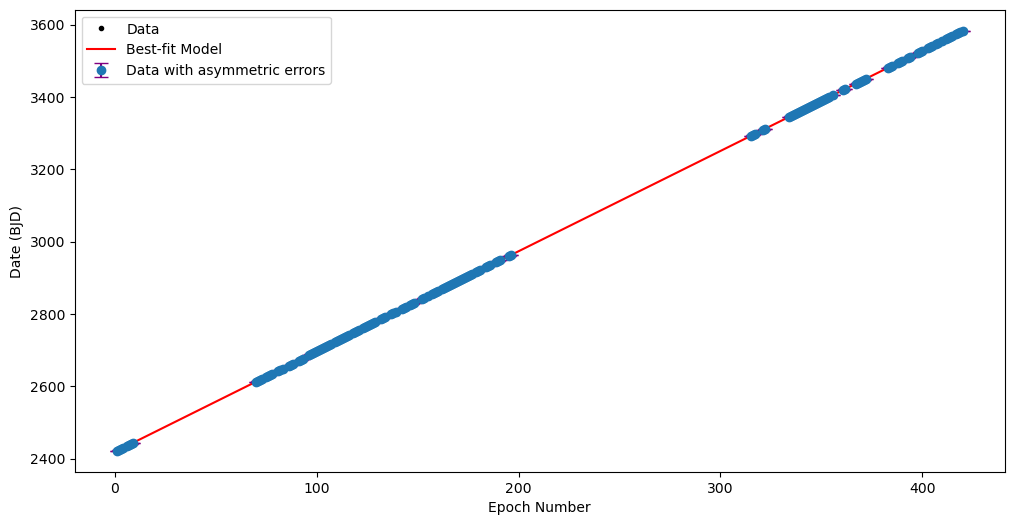

In [25]:
# Calculate and display median and uncertainties for t0
answers = []
err = []
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [2.1, 50, 97.9])
    q = np.diff(mcmc)
    txt = r"\mathrm{{{3}}} = {0:.7f}_{{-{1:.7f}}}^{{+{2:.7f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    answers.append(mcmc[1])
    err.append(q[0])
    err.append(q[1])
    display(Math(txt))

# Update model with best-fit t0 to plot the fitted light curve
s = answers[0]
t0 = answers[1]    
best_fit = ttv_function(np.asarray(timeepoch),s,t0)  

# Plot data and best-fit model for the current epoch
plt.figure(figsize=(12, 6))
plt.plot(np.asarray(timeepoch), t0values, "k.", label="Data")
plt.plot(np.asarray(timeepoch), best_fit, "r-", label="Best-fit Model")
error = [lowererrminutes, uppererrminutes]
plt.errorbar(np.asarray(timeepoch), t0values, yerr=dayerror, ecolor='purple', fmt='o', capsize=5, label="Data with asymmetric errors")
plt.xlabel("Epoch Number")
plt.ylabel("Date (BJD)")
plt.legend()
plt.show()

In [26]:
CTTresiduals = []
CTTresidualsminutes = []
CTTresidualsseconds = []
CTTresiduals = np.array([(t0values - (epoch*answers[0] + answers[1])) for t0values, epoch in zip(t0values, timeepoch)])
CTTresidualsminutes = CTTresiduals * 60 * 24
CTTresidualsseconds = CTTresiduals * 60 * 24 * 60
print(CTTresidualsseconds)

[-7.34067752e+01 -9.97174043e+01 -1.26345337e+02 -9.12383442e+01
             nan  3.11295502e+01 -8.78008167e+01 -4.14665807e+01
 -1.28052767e+02             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan         

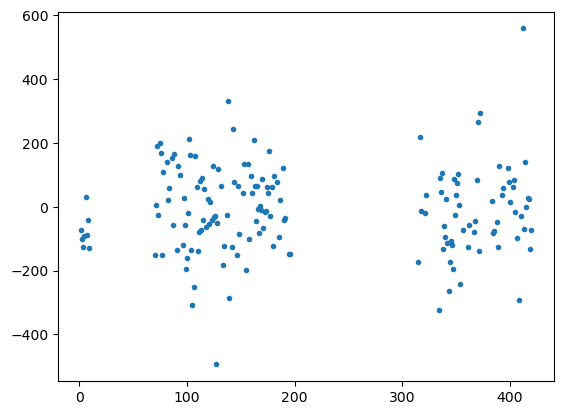

In [27]:
plt.plot(timeepoch, CTTresidualsseconds, '.')

In [28]:
#MCMC Fitting for the Actual System Parameters

In [29]:
# Define Priors - The boundaries on what is allowed for our model
## Returning 0 shows that the values are valid for the model
## Returning -infinity shows that the values are not valid for the model
def log_prior(theta):
    ## Get our parameters for the model
    s, t0 = theta
    
    ## Check if the t0 value is less than or greater than 0.1
    if -30<s<30: # !! Change these if you want a more constrained fit
        return 0
    
    return -np.inf

In [30]:
# Define Likelihood Function
def log_likelihood(parameters, time, ttv, ttv_err):
    ## Get our parameters for the model
    s, t0 = parameters
    
    ## Check our parameters against our priors
    ## If lp is negative infinity, the values are invalid, a model will not be calculated, 
    ##  and these values will be labeled as very unlikely
    lp = log_prior(parameters)
    if not np.isfinite(lp):
        return -np.inf
    
    ## Generate a new version of our model using our current x values
    model = s*time+t0
    
    ## Compare using chi squared
    chisquared = np.nansum(((ttv-model)**2/(ttv_err**2)))
    ## Return our chi squared value for later evaluation done by emcee
    return (-0.5 * chisquared)

100%|██████████| 5000/5000 [00:08<00:00, 556.86it/s]


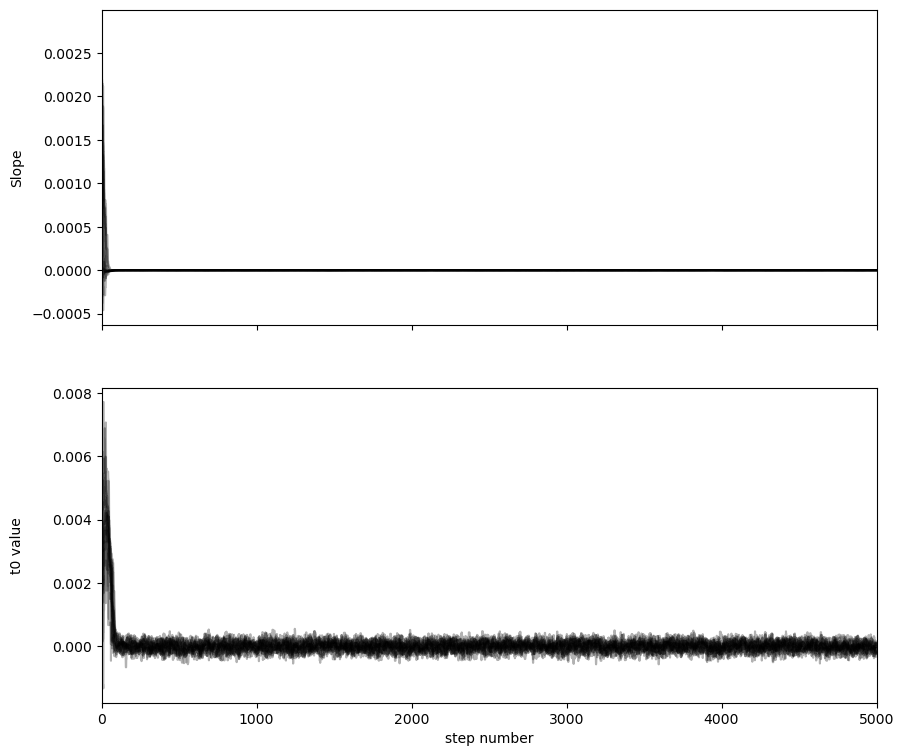

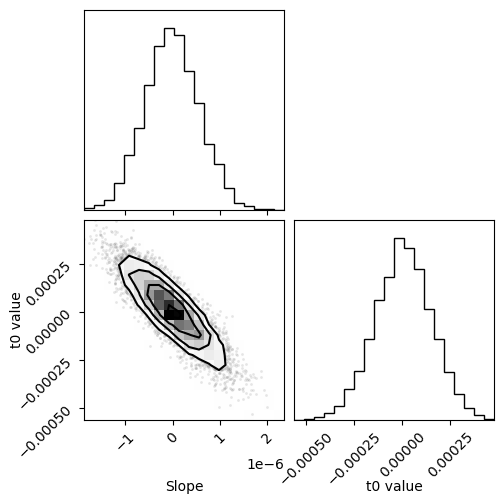

In [31]:
# Example data (replace `t`, `flux`, and `error` with your actual data arrays)
# t, flux, error = ... (define these as lists of arrays per epoch)
# epochs = ... (define epochs array)

ndim = 2
nwalkers = 16

random_additions = np.random.rand(nwalkers, ndim) * 0.003

p0 = np.add(np.asarray([0,0]), random_additions)

# Declare the sampler for the current epoch
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_likelihood,
    args=(np.asarray(timeepoch), np.asarray(CTTresiduals), np.asarray(dayerror))
)
sampler.run_mcmc(p0, 5000, progress=True)

    
fig, axes = plt.subplots(ndim, figsize=(10, 9), sharex=True)
samples = sampler.get_chain()
labels = ['Slope', 't0 value']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

# Discard burn-in samples, flatten chain, and plot corner plot for posterior distribution
flat_samples = sampler.get_chain(discard=1000, thin=11, flat=True)
fig = corner.corner(flat_samples, labels=labels)
plt.show()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

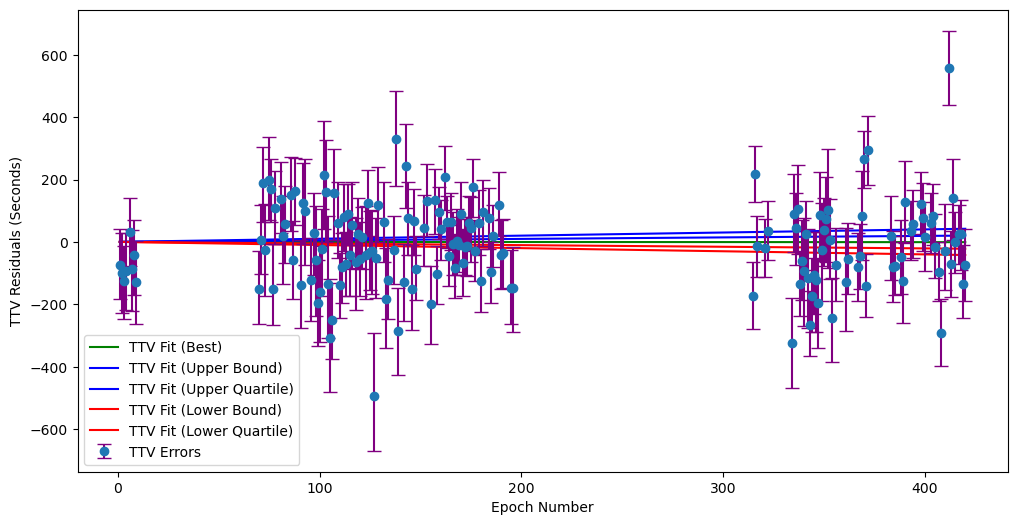

In [32]:
# Calculate and display median and uncertainties for t0
answers = []
err = []
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [2.1, 50, 97.9])
    q = np.diff(mcmc)
    txt = r"\mathrm{{{3}}} = {0:.7f}_{{-{1:.7f}}}^{{+{2:.7f}}}"
    txt = txt.format((mcmc[1]*24*60*60), (q[0]*24*60*60), (q[1]*24*60*60), labels[i])
    answers.append((mcmc[1]*24*60*60))
    err.append((q[0]*24*60*60))
    err.append((q[1]*24*60*60))
    display(Math(txt))

# Update model with best-fit t0 to plot the fitted light curve
s = answers[0]
t0 = answers[1]    
best_fit = ttv_function(np.asarray(timeepoch),s,t0)  
upper_fit = ttv_function(np.asarray(timeepoch), s + err[1], t0)
mid_fit1 = ttv_function(np.asarray(timeepoch), s + 0.05, t0)
lower_fit = ttv_function(np.asarray(timeepoch), s - err[0], t0)
mid_fit2 = ttv_function(np.asarray(timeepoch), s - 0.05, t0)

# Plot data and best-fit model for the current epoch
plt.figure(figsize=(12, 6))
plt.plot(np.asarray(timeepoch), CTTresiduals*24*60*60, "k.")
plt.plot(np.asarray(timeepoch), best_fit, "g-", label="TTV Fit (Best)")
plt.plot(np.asarray(timeepoch), upper_fit, "b-", label="TTV Fit (Upper Bound)")
plt.plot(np.asarray(timeepoch), mid_fit1, "b-", label="TTV Fit (Upper Quartile)")
plt.plot(np.asarray(timeepoch), lower_fit, "r-", label="TTV Fit (Lower Bound)")
plt.plot(np.asarray(timeepoch), mid_fit2, "r-", label="TTV Fit (Lower Quartile)")
plt.errorbar(np.asarray(timeepoch), CTTresiduals*24*60*60, yerr=np.array(dayerror)*24*60*60, ecolor='purple', fmt='o', capsize=5, label="TTV Errors")
plt.xlabel("Epoch Number")
plt.ylabel("TTV Residuals (Seconds)")
plt.legend()
plt.show()